In [ ]:
# population analysis

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import itertools
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

In [4]:
df = pd.read_hdf('/home/niell_lab/data/freely_moving_ephys/batch_files/062421/updated_ephys_props_062421.h5')
df1 = df.reset_index()

In [5]:
list(df.columns.values)

['index',
 'Amplitude',
 'ContamPct',
 'KSLabel',
 'amp',
 'best_ellipse_fit_m',
 'best_ellipse_fit_r',
 'ch',
 'depth',
 'fm1_accT',
 'fm1_c_range',
 'fm1_crf_cent',
 'fm1_crf_err',
 'fm1_crf_tuning',
 'fm1_dEye',
 'fm1_dHead',
 'fm1_downsacc_avg',
 'fm1_downsacc_avg_comp_dEye',
 'fm1_downsacc_avg_comp_dHead',
 'fm1_downsacc_avg_gaze_shift_dEye',
 'fm1_downsacc_avg_gaze_shift_dHead',
 'fm1_eyeT',
 'fm1_glm_cc',
 'fm1_glm_receptive_field',
 'fm1_gz',
 'fm1_n_spikes',
 'fm1_phi',
 'fm1_pitch',
 'fm1_pitch_interp',
 'fm1_rate',
 'fm1_roll',
 'fm1_roll_interp',
 'fm1_spikeT',
 'fm1_spikeTraw',
 'fm1_spike_rate_vs_gx_cent',
 'fm1_spike_rate_vs_gx_err',
 'fm1_spike_rate_vs_gx_tuning',
 'fm1_spike_rate_vs_gy_cent',
 'fm1_spike_rate_vs_gy_err',
 'fm1_spike_rate_vs_gy_tuning',
 'fm1_spike_rate_vs_gz_cent',
 'fm1_spike_rate_vs_gz_err',
 'fm1_spike_rate_vs_gz_tuning',
 'fm1_spike_rate_vs_phi_cent',
 'fm1_spike_rate_vs_phi_err',
 'fm1_spike_rate_vs_phi_tuning',
 'fm1_spike_rate_vs_pitch_cent',
 '

In [88]:
for ind, row in df1.iterrows():
    if type(row['fm1_dHead']) != np.ndarray and type(row['fm1_dHead']) != float:
        df1.at[ind, 'peak_fr_relative_to_dHead'] = np.nanmax(row['fm1_rate']) / np.nanmax(df1.loc[0,'fm1_dHead'](df1.loc[0,'fm1_eyeT'][0:-1:10].values)) # peak firing rate relative to peak angular velocity of head

(array([11., 23., 99., 23., 23.,  7.,  1.,  1.,  3.,  1.]),
 array([ 3.65556809,  9.13892022, 14.62227234, 20.10562447, 25.5889766 ,
        31.07232873, 36.55568086, 42.03903299, 47.52238512, 53.00573725,
        58.48908938]),
 <a list of 1 Patch objects>)

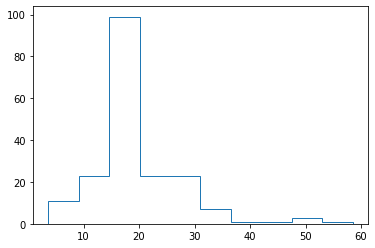

In [95]:
plt.hist(df1['peak_fr_relative_to_dHead'], histtype='step')

In [ ]:
plt.hist(df1['fr']/)

In [ ]:
# waveform, seperating out narrow- and broad-spiking units
plt.subplots(4,4, figsize=(20,15))

plt.subplot(4,4,1)
plt.title('normalized waveform')
df1['norm_waveform'] = df1['waveform'].copy()
for ind, row in df1.iterrows():
    if type(row['waveform']) != float:
        starting_val = np.mean(row['waveform'][:6])
        center_waveform = [i-starting_val for i in row['waveform']]
        norm_waveform = center_waveform / -np.min(center_waveform)
        plt.plot(norm_waveform)
        df1.at[ind, 'waveform_trough_width'] = len(norm_waveform[norm_waveform < -0.2])
        df1.at[ind, 'AHP'] = norm_waveform[27]
        df1.at[ind, 'waveform_peak'] = norm_waveform[18]
        df1.at[ind, 'norm_waveform'] = norm_waveform
plt.ylim([-1,1]); plt.ylabel('millivolts'); plt.xlabel('msec')

plt.subplot(4,4,2)
plt.hist(df1['waveform_trough_width'],bins=range(3,35))
plt.xlabel('trough width')

plt.subplot(4,4,3)
plt.xlabel('AHP')
plt.hist(df1['AHP'],bins=60); plt.xlim([-1,1])

plt.subplot(4,4,4)
for ind, row in df1.iterrows():
    if row['AHP'] <=0 and row['waveform_peak'] < 0:
        plt.plot(row['norm_waveform'], 'g')
        df1.at[ind, 'waveform_type'] = 'narrow'
    elif row['AHP'] > 0 and row['waveform_peak'] < 0:
        plt.plot(row['norm_waveform'], 'b')
        df1.at[ind, 'waveform_type'] = 'broad'
    else:
        df1.at[ind, 'waveform_type'] = 'bad'

plt.subplot(4,4,5)
plt.plot(df1['waveform_trough_width'][df1['waveform_peak'] < 0][df1['waveform_type']=='broad'], df1['AHP'][df1['waveform_peak'] < 0][df1['waveform_type']=='broad'], 'b.')
plt.plot(df1['waveform_trough_width'][df1['waveform_peak'] < 0][df1['waveform_type']=='narrow'], df1['AHP'][df1['waveform_peak'] < 0][df1['waveform_type']=='narrow'], 'g.')
plt.ylabel('AHP'); plt.xlabel('waveform trough width')

km_labels = KMeans(n_clusters=2).fit(list(df1['norm_waveform'][df1['waveform_peak'] < 0].to_numpy())).labels_
count = 0
for ind, row in df1.iterrows():
    if row['waveform_peak'] < 0:
        df1.at[ind, 'waveform_km_label'] = km_labels[count]
        count = count+1
        
plt.subplot(4,4,6)
plt.plot(df1['waveform_trough_width'][df1['waveform_peak'] < 0][df1['waveform_km_label']==0], df1['AHP'][df1['waveform_peak'] < 0][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['waveform_trough_width'][df1['waveform_peak'] < 0][df1['waveform_km_label']==1], df1['AHP'][df1['waveform_peak'] < 0][df1['waveform_km_label']==1], 'k.')
plt.legend(['kmeans=0', 'kmeans=1'])
plt.ylabel('AHP'); plt.xlabel('waveform trough width')

plt.subplot(4,4,7)
for ind, row in df1.iterrows():
    if row['waveform_km_label']==0:
        plt.plot(row['norm_waveform'], 'r')
    elif row['waveform_km_label']==1:
        plt.plot(row['norm_waveform'], 'k')

plt.subplot(4,4,8)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(list(df1['norm_waveform'][df1['waveform_peak'] < 0].to_numpy()))
pca_ref = df1[df1['waveform_peak'] < 0].copy()
inds = pca_ref.copy().drop(columns='level_0').reset_index()
for i, row in inds.iterrows():
    ind = int(row['index'])
    df1.at[ind,'wv_pca0'] = principal_components[i,0]
    df1.at[ind,'wv_pca1'] = principal_components[i,1]
    if df1.loc[ind, 'waveform_km_label']==0:
        plt.plot(principal_components[i,0].T,principal_components[i,1].T,'r.')
    elif df1.loc[ind, 'waveform_km_label']==1:
        plt.plot(principal_components[i,0],principal_components[i,1].T,'k.')
plt.ylabel('PCA1'); plt.xlabel('PCA0')
plt.legend(['r.','k.'],['kmeans=0', 'kmeans=1'])

plt.subplot(4,4,9)
plt.hist(df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0],color='r',bins=np.arange(-30,31,5),alpha=.5)
plt.xlim([-30,30])
plt.plot([0,0],[0,16],'k')
plt.xlabel('channels above or below center of layer 4')

plt.hist(df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1],color='k',bins=np.arange(-30,31,5),alpha=.5)
plt.xlim([-30,30])
plt.plot([0,0],[0,16],'k')

plt.subplot(4,4,10)
for ind, row in df1.iterrows():
    tuning = row['hf1_wn_crf_tuning']
    if type(tuning) == np.ndarray:
        tuning = tuning[~np.isnan(tuning)]
        # thresh out units which have a small response to contrast, even if the modulation index is large
        df1.at[ind, 'responsive_to_contrast'] = np.abs(tuning[-2] - tuning[1]) > 1
    else:
        df1.at[ind, 'responsive_to_contrast'] = False
plt.plot(df1['hf1_wn_crf_modind'][df1['responsive_to_contrast']==True][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['responsive_to_contrast']==True][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['hf1_wn_crf_modind'][df1['responsive_to_contrast']==True][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['responsive_to_contrast']==True][df1['waveform_km_label']==1], 'k.')
plt.xlabel('contrast response modulation index'); plt.ylabel('depth relative to layer 4')
good = ~np.isnan(df['hf4_revchecker_ch_lfp_relative_depth']) * ~np.isnan(df['hf1_wn_crf_modind'])
depth = df['hf4_revchecker_ch_lfp_relative_depth'][good]
plt.ylim([32,-32])
# crfmi = df['hf1_wn_crf_modind'][good]
# corr = scipy.stats.pearsonr(depth,crfmi)
# plt.title('R='+str(np.round(corr[0],3))+' p='+str(np.round(corr[1],3)))

for sf in ['low','mid','high']:
    df1['norm_ori_tuning_'+sf] = df1['hf3_gratings_ori_tuning'].copy().astype(object)
for ind, row in df1.iterrows():
    if type(row['hf3_gratings_ori_tuning']) == np.ndarray and ~np.isnan(row['hf3_gratings_drift_spont']):
        orientations = np.array([np.array(i) for i in [item for sublist in row['hf3_gratings_ori_tuning'] for item in sublist]]).reshape(8,3)
        for sfnum in range(3):
            sf = ['low','mid','high'][sfnum]
            df1.at[ind,'norm_ori_tuning_'+sf] = orientations[:,sfnum] - row['hf3_gratings_drift_spont']
        mean_for_sf = np.array([np.mean(df1.at[ind,'norm_ori_tuning_low']), np.mean(df1.at[ind,'norm_ori_tuning_mid']), np.mean(df1.at[ind,'norm_ori_tuning_high'])])
        mean_for_sf[mean_for_sf<0] = 0
        df1.at[ind,'sf_pref'] = ((mean_for_sf[0]*1)+(mean_for_sf[1]*2)+(mean_for_sf[2]*3))/np.sum(mean_for_sf)
        df1.at[ind,'responsive_to_gratings'] = [True if np.max(mean_for_sf)>2 else False][0]
    else:
        for sfnum in range(3):
            sf = ['low','mid','high'][sfnum]
            df1.at[ind,'norm_ori_tuning_'+sf] = None
            
plt.subplot(4,4,11)
use = df1[df1['responsive_to_gratings']==True]
for ind, row in use.iterrows():
    if row['waveform_km_label'] == 0:
        plt.plot(row['hf3_gratings_drift_spont'], row['hf4_revchecker_ch_lfp_relative_depth'],'r.')
    elif row['waveform_km_label'] == 1:
        plt.plot(row['hf3_gratings_drift_spont'], row['hf4_revchecker_ch_lfp_relative_depth'],'k.')
plt.ylabel('depth relative to layer 4')
plt.xlabel('gratings spont rate')
plt.ylim([32,-32])

plt.subplot(4,4,12)
# plot prefered spatial frequency for all gratings-responsive units
plt.hist(df1['sf_pref'][df1['responsive_to_gratings']==True], bins=np.arange(1,3.25,0.25))
plt.xlabel('prefered spatial frequency'); plt.ylabel('unit count')

plt.subplot(4,4,13)
for ind, row in df1.iterrows():
    if ~np.isnan(row['sf_pref']):
        best_sf_pref = int(np.round(row['sf_pref']))
        df1.at[ind, 'osi_for_sf_pref'] = row[(['hf3_gratings_osi_low','hf3_gratings_osi_mid','hf3_gratings_osi_high'][best_sf_pref-1])]
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], df1['fm1_wn_spike_rate_vs_roll_modind_pos'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], df1['fm1_wn_spike_rate_vs_roll_modind_pos'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], 'k.')
plt.ylabel('positive head roll tuning modulation index'); plt.xlabel('prefered orientation selectivity index')

plt.subplot(4,4,14)
for ind, row in df1.iterrows():
    if ~np.isnan(row['sf_pref']):
        best_sf_pref = int(np.round(row['sf_pref']))
        df1.at[ind, 'osi_for_sf_pref'] = row[(['hf3_gratings_osi_low','hf3_gratings_osi_mid','hf3_gratings_osi_high'][best_sf_pref-1])]
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], df1['fm1_wn_spike_rate_vs_roll_modind_neg'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], df1['fm1_wn_spike_rate_vs_roll_modind_neg'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], 'k.')
plt.ylabel('negative head roll tuning modulation index'); plt.xlabel('prefered orientation selectivity index')

plt.subplot(4,4,15)
for ind, row in df1.iterrows():
    if ~np.isnan(row['sf_pref']):
        best_sf_pref = int(np.round(row['sf_pref']))
        df1.at[ind, 'osi_for_sf_pref'] = row[(['hf3_gratings_osi_low','hf3_gratings_osi_mid','hf3_gratings_osi_high'][best_sf_pref-1])]
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], df1['fm1_wn_spike_rate_vs_pitch_modind_pos'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], df1['fm1_wn_spike_rate_vs_pitch_modind_pos'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], 'k.')
plt.ylabel('positive head pitch tuning modulation index'); plt.xlabel('prefered orientation selectivity index')

plt.subplot(4,4,16)
for ind, row in df1.iterrows():
    if ~np.isnan(row['sf_pref']):
        best_sf_pref = int(np.round(row['sf_pref']))
        df1.at[ind, 'osi_for_sf_pref'] = row[(['hf3_gratings_osi_low','hf3_gratings_osi_mid','hf3_gratings_osi_high'][best_sf_pref-1])]
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], df1['fm1_wn_spike_rate_vs_pitch_modind_neg'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], df1['fm1_wn_spike_rate_vs_pitch_modind_neg'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], 'k.')
plt.ylabel('negative head pitch tuning modulation index'); plt.xlabel('prefered orientation selectivity index')

plt.tight_layout()
plt.show()

In [ ]:
plt.subplots(4,3, figsize=(15,15))

plt.subplot(4,3,1)
for ind, row in df1.iterrows():
    if row['waveform_km_label']==0:
        plt.plot(row['norm_waveform'], 'r')
    elif row['waveform_km_label']==1:
        plt.plot(row['norm_waveform'], 'k')

plt.subplot(4,3,2)
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['osi_for_sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('prefered orientation selectivity index'); plt.ylim([32,-32])

plt.subplot(4,3,3)
plt.plot(df1['sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['sf_pref'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['responsive_to_gratings']==True][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('pref sf'); plt.ylim([32,-32])

plt.subplot(4,3,4)
plt.plot(df1['fm1_wn_spike_rate_vs_roll_modind_pos'][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['fm1_wn_spike_rate_vs_roll_modind_pos'][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('positive head roll tuning modulation index'); plt.ylim([32,-32])

plt.subplot(4,3,5)
plt.plot(df1['fm1_wn_spike_rate_vs_roll_modind_neg'][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['fm1_wn_spike_rate_vs_roll_modind_neg'][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('negative head roll tuning modulation index'); plt.ylim([32,-32])

plt.subplot(4,3,6)
plt.plot(df1['fm1_wn_spike_rate_vs_pitch_modind_pos'][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['fm1_wn_spike_rate_vs_pitch_modind_pos'][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('positive head pitch tuning modulation index'); plt.ylim([32,-32])

plt.subplot(4,3,7)
plt.plot(df1['fm1_wn_spike_rate_vs_pitch_modind_neg'][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['fm1_wn_spike_rate_vs_pitch_modind_neg'][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('negative head pitch tuning modulation index'); plt.ylim([32,-32])

plt.subplot(4,3,8)
plt.plot(df1['fm1_wn_spike_rate_vs_theta_modind_pos'][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['fm1_wn_spike_rate_vs_theta_modind_pos'][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('positive eye theta tuning modulation index'); plt.ylim([32,-32])

plt.subplot(4,3,9)
plt.plot(df1['fm1_wn_spike_rate_vs_theta_modind_neg'][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['fm1_wn_spike_rate_vs_theta_modind_neg'][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('negative eye theta tuning modulation index'); plt.ylim([32,-32])

plt.subplot(4,3,10)
plt.plot(df1['fm1_wn_spike_rate_vs_phi_modind_pos'][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['fm1_wn_spike_rate_vs_phi_modind_pos'][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('positive eye phi tuning modulation index'); plt.ylim([32,-32])

plt.subplot(4,3,11)
plt.plot(df1['fm1_wn_spike_rate_vs_phi_modind_neg'][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0], 'r.')
plt.plot(df1['fm1_wn_spike_rate_vs_phi_modind_neg'][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1], 'k.')
plt.ylabel('depth relative to layer 4'); plt.xlabel('negative eye phi tuning modulation index'); plt.ylim([32,-32])

plt.subplot(4,3,12)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
panels = ['fm1_upsacc_avg_gaze_shift_dEye_modind_t0',
 'fm1_downsacc_avg_gaze_shift_dEye_modind_t0',
 'fm1_upsacc_avg_gaze_shift_dEye_modind_t100',
 'fm1_downsacc_avg_gaze_shift_dEye_modind_t100',
 'fm1_upsacc_avg_comp_dEye_modind_t0',
 'fm1_downsacc_avg_comp_dEye_modind_t0',
 'fm1_upsacc_avg_comp_dEye_modind_t100',
 'fm1_downsacc_avg_comp_dEye_modind_t100',
 'fm1_wn_upsacc_avg_gaze_shift_dHead_modind_t0',
 'fm1_downsacc_avg_gaze_shift_dHead_modind_t0',
 'fm1_upsacc_avg_gaze_shift_dHead_modind_t100',
 'fm1_downsacc_avg_gaze_shift_dHead_modind_t100',
 'fm1_upsacc_avg_comp_dHead_modind_t0',
 'fm1_downsacc_avg_comp_dHead_modind_t0',
 'fm1_upsacc_avg_comp_dHead_modind_t100',
 'fm1_downsacc_avg_comp_dHead_modind_t100']
j = 0
plt.subplots(4,4,figsize=(20,15))
for i in panels:
    j = j + 1
    plt.subplot(4,4,j)
    plt.plot(df1[i][df1['waveform_km_label']==0], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==0], 'r.')
    plt.plot(df1[i][df1['waveform_km_label']==1], df1['hf4_revchecker_ch_lfp_relative_depth'][df1['waveform_km_label']==1], 'k.')
    plt.ylabel('depth relative to layer 4'); plt.xlabel(i); plt.ylim([32,-32])